#### Import dataset

In [42]:
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from training import *
from utils import *

selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']


In [43]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']) \
  .dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']) \
  .dropna(subset=['egtm'])

data = pd.concat([bgu, bdu]) \
  .sort_values('reportts') \
  .reset_index() \
  .drop(columns=['index'])

bgu.loc[bgu['oat'].isna(), ['oat']] = bgu.loc[bgu['oat'].isna(), :]['tat']
bdu.loc[bdu['oat'].isna(), ['oat']] = bdu.loc[bdu['oat'].isna(), :]['tat']

#### Generate recursive features for n previous data points

In [44]:
def get_recursive_features(data: List[pd.DataFrame], features = [], n_back = 1):
  result = []
  rest_features = list(set(data[0].columns) - set(features))
  assert len(rest_features + features) == len(data[0].columns)
  
  for acdata in data:
    for pos in [1, 2]:
      df = acdata[acdata['pos'] == pos].copy().reset_index()
      if df.shape[0] == 0:
        continue
      X = df[features]
      X_aug = X.copy()
      for offset in range(1, n_back + 1):
        features_back = [f"{i}_{offset}" for i in features]
        X_aug.loc[0:offset, features_back] =  X.iloc[0,:].to_numpy()
        X_aug.loc[offset:, features_back] = X.iloc[:-offset,:].to_numpy()
      
      X_aug.loc[:, rest_features] = df[rest_features]
      result.append(X_aug)
  
  result = pd.concat(result) \
              .sort_values('reportts' if 'reportts' in rest_features else 'pos') \
              .reset_index() \
              .drop(columns=['index'])
  return result


In [45]:
from sklearn.linear_model import Ridge
from training import *

def train_model(X, y):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]
  assert len(X_train) + len(X_test) == len(X)

  model = Ridge(alpha=0.2)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [46]:

y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']
features = ['egtk', 'oat', 'tat', 'n1ak', 'n2ak', 'prv', 'mn', 'nfk']

data = build_dataset(
  [correct(bgu), correct(bdu)], 
  y_cols, 
  meta_cols, 
  features,
  n_back=0,
)

X = data.drop(columns=(meta_cols + y_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)

metrics

{'rmse': 3.95063, 'mae': 3.12537, 'r2': -1.79544, 'mape': 0.15366}

In [47]:
best_pred = (predicted_train.copy(), predicted_test.copy())
best_r2 = metrics['r2']
history = [metrics['r2']]
pred_history = []

for i in range(1, 30):
  data = build_dataset(
    [correct(bgu), correct(bdu)], 
    y_cols, 
    meta_cols, 
    features,
    n_back=i,
  )

  X = data.drop(columns=['egtm', 'acnum', 'pos', 'reportts'])
  y = data['egtm']
  metrics, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
  history.append(metrics['r2'])\
  
  if metrics['r2'] > best_r2:
    best_r2 = metrics['r2']
    best_pred = (predicted_train.copy(), predicted_test.copy())

  pred_history.append((predicted_train.copy(), predicted_test.copy()))
  
  print(f"{i} features back: rmse={metrics['rmse']:.3f} mae={metrics['mae']:.3f} r2={metrics['r2']:.3f}")
  # print(f"Total features: {X.shape[1]}")

1 features back: rmse=3.082 mae=2.457 r2=-0.701
2 features back: rmse=2.660 mae=2.097 r2=-0.268
3 features back: rmse=2.405 mae=1.899 r2=-0.036
4 features back: rmse=2.215 mae=1.765 r2=0.121
5 features back: rmse=2.074 mae=1.659 r2=0.229
6 features back: rmse=1.967 mae=1.576 r2=0.307
7 features back: rmse=1.882 mae=1.513 r2=0.365
8 features back: rmse=1.793 mae=1.434 r2=0.424
9 features back: rmse=1.718 mae=1.376 r2=0.472
10 features back: rmse=1.652 mae=1.325 r2=0.511
11 features back: rmse=1.596 mae=1.288 r2=0.544
12 features back: rmse=1.542 mae=1.252 r2=0.574
13 features back: rmse=1.493 mae=1.226 r2=0.601
14 features back: rmse=1.452 mae=1.198 r2=0.622
15 features back: rmse=1.414 mae=1.174 r2=0.642
16 features back: rmse=1.390 mae=1.151 r2=0.654
17 features back: rmse=1.377 mae=1.133 r2=0.660
18 features back: rmse=1.366 mae=1.123 r2=0.666
19 features back: rmse=1.353 mae=1.113 r2=0.672
20 features back: rmse=1.341 mae=1.099 r2=0.678
21 features back: rmse=1.334 mae=1.089 r2=0.68

Text(0, 0.5, 'RMSE')

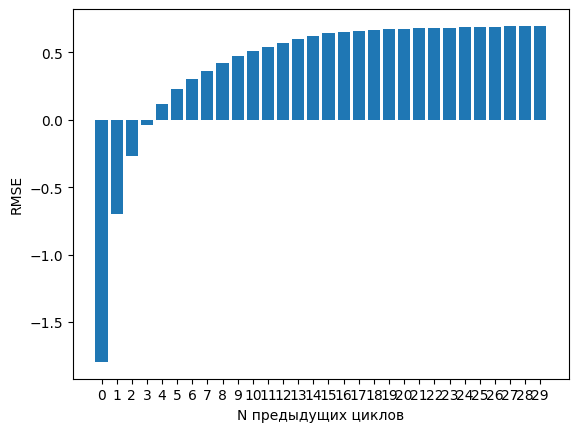

In [53]:
plt.bar(x=range(0, 30), height=history[:30])
plt.xticks(range(0, 30))
plt.xlabel("N предыдущих циклов")
plt.ylabel("RMSE")

In [49]:
metrics

{'rmse': 1.30034, 'mae': 1.06503, 'r2': 0.69715, 'mape': 0.05199}

In [50]:
import matplotlib.pyplot as plt

# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=0.3), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=0.3), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'], sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.title(f'Linear model of EGTM on {acnum} engine {pos}, Gas path params' if title is None else title)
  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()

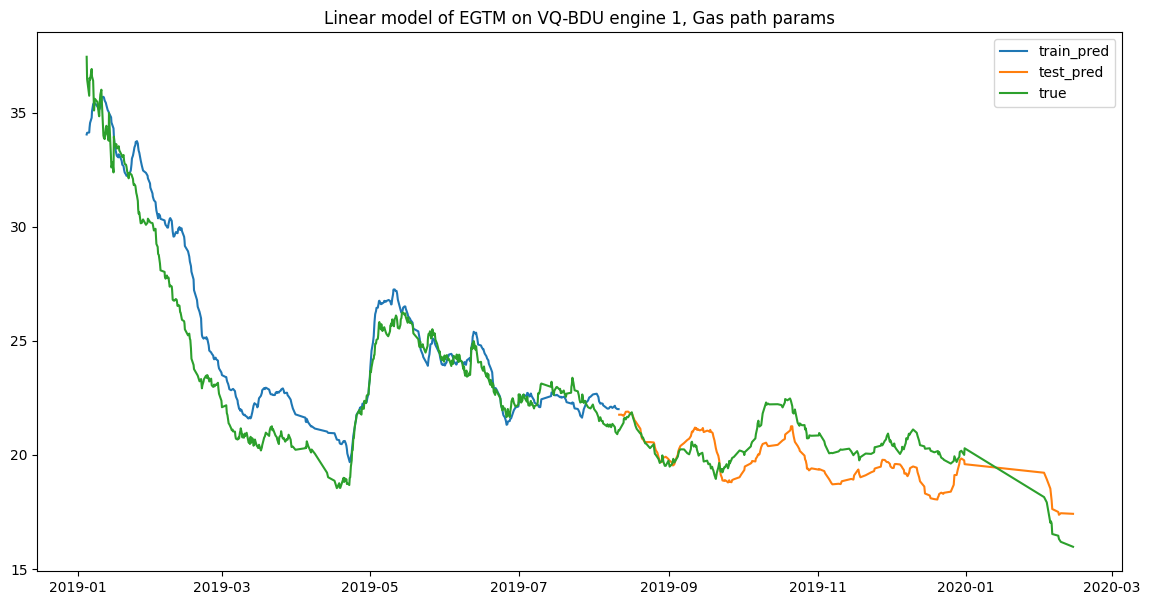

In [54]:
plot_predictions(data, 'VQ-BDU', 1, train_i, best_pred[1], best_pred[0], is_smooth=True)

In [52]:
# for (pred_train, pred_test) in pred_history:
#   plot_predictions(data, 'VQ-BDU', 2, train_i, pred_test, pred_train, is_smooth=True, figsize=(6, 3))